# Convolutional Neural Networks

In this tutorial we continue our journey in deep learning by looking at convolutional neural networks or ConvNets. We start by re viewing how convolution work. Then we try to solve a steel microstructure classification problem by using a CNN. We explore how data augmentation, regularization and other gradient descent algorithms may help to better train the model.

Run the notebook in Google colab:
https://colab.research.google.com/github/heprom/cvml/blob/main/corrections/CNN_cor.ipynb

You should use GPU acceleration to train your network, on google colab, before starting working, go to Execution -> Modifier le Type d'Execution -> select GPU as hardware accelerator

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt, cm

## Understanding convolutions

In thisfirst section, we experiment convolutions on images using simple `numpy` operations. We first work with a single channel image from MNIST and then a 3 channel RGB image of a cat.

In [6]:
from sklearn.datasets import load_digits
mnist = load_digits()

create a variable `image` to hold the first $8\times8$ image in the data set

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


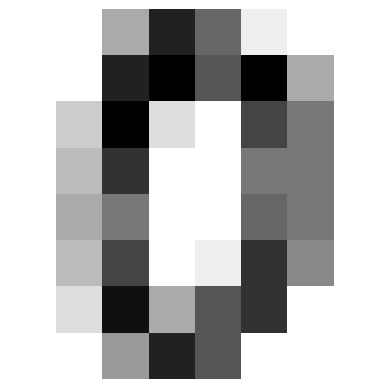

In [7]:
image = mnist['images'][0]
print(image)
plt.imshow(image, cmap=cm.gray_r)
plt.axis('off')
plt.show()

create the following $3\times 3$ kernel as a numpy array: $\left[\begin{array}{ccc}-1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1\end{array}\right]$

In [8]:
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
print(kernel)

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


pad the image with zeros.

In [9]:
kernel_size = kernel.shape[0]
pad = (kernel_size - 1) // 2
im = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
print('paded image size is now {}'.format(im.shape))

paded image size is now (10, 10)


convolve the kernel with the image. Create an algorithm using for loops to output the convolution to a new variable `conv`.

output size of the convolution is (8, 8)


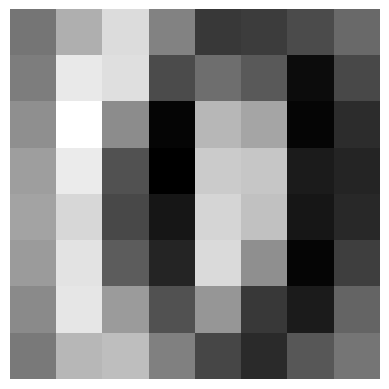

In [10]:
conv = np.empty_like(image)

for i in range(pad, im.shape[0] - pad):
    for j in range(pad, im.shape[1] - pad):
        subset = im[i-pad:i+pad+1, j-pad:j+pad+1]
        conv[i-pad, j-pad] = np.dot(kernel.ravel(), subset.ravel())  # element-wise multiplication

print('output size of the convolution is {}'.format(conv.shape))
plt.imshow(conv, cmap=cm.gray)
plt.axis('off')
plt.show()

now this works, make a function called `convolve` which takes for input an image, a kernel and output the result of the convolution. Assume image is in form (n x m x channels) and represented by floats in the [0, 1] range.

In [11]:
def convolve(image, kernel):
    kernel_size = kernel.shape[0]
    pad = (kernel_size - 1) // 2
    im = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
    conv = np.empty_like(image)

    for i in range(pad, im.shape[0] - pad):
        for j in range(pad, im.shape[1] - pad):
            # get the (i, j) subset of size (2 x pad + 1)
            subset = im[i - pad:i + pad + 1, j - pad:j + pad + 1]
            # perform the convolution
            conv[i - pad, j - pad] = (subset * kernel).sum()
    conv = (conv - conv.min()) / (conv.max() - conv.min())  # normalization
    return conv

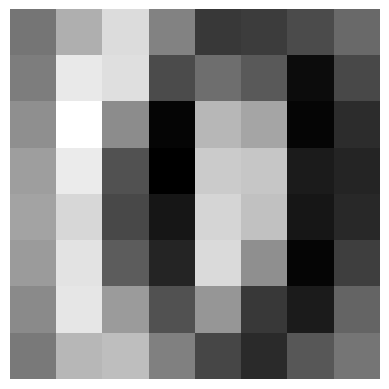

In [12]:
plt.imshow(convolve(image, kernel), cmap=cm.gray)
plt.axis('off')
plt.show()

Now let's work with a 3 channel RGB image. Load it, convert if to float representation and in gray scale mode.

In [17]:
from skimage import data
cat = data.chelsea().astype(float)
cat = np.mean(cat, axis=2)  # convert to gray scale
cat /= cat.max()  # with float representation, the range is [0, 1]
print(cat.shape)
print(cat.dtype)
print(cat.max())

(300, 451)
float64
1.0


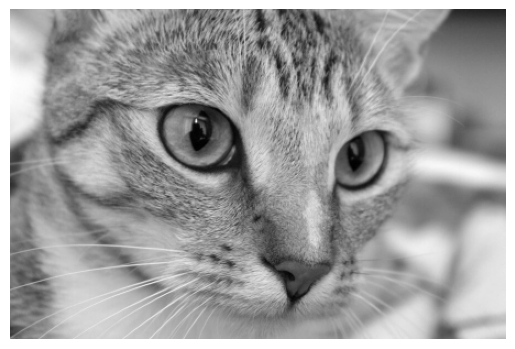

In [18]:
plt.imshow(cat, cmap=cm.gray)
plt.axis('off')
plt.show()

create all the following kernel and try them out:

 - Blur kernel: $\left[\begin{array}{ccc}1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1\end{array}\right]$
 - Laplacian kernel: $\left[\begin{array}{ccc}0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0\end{array}\right]$
 - Emboss kernel: $\left[\begin{array}{ccc}-2 & -1 & 0 \\ -1 & 1 & 1 \\ 0 & 1 & 2\end{array}\right]$

In [19]:
# blur filters
blur3 = np.array(([1, 1, 1], [1, 1, 1], [1, 1, 1]))
blur5 = np.ones((5, 5))
blur7 = np.ones((7, 7))

# sharpen
sharpen = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]))

# Laplacian kernel
laplacian = np.array(([0, 1, 0], [1, -4, 1], [0, 1, 0]))

# construct the Sobel x-axis kernel
sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

# construct the Sobel y-axis kernel
sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))

# construct an emboss kernel
emboss = np.array(([-2, -1, 0], [-1, 1, 1], [0, 1, 2]))

kernels = [blur3, sharpen, laplacian, emboss]
kernel_labels = ['blur3', 'sharpen', 'laplacian', 'emboss']

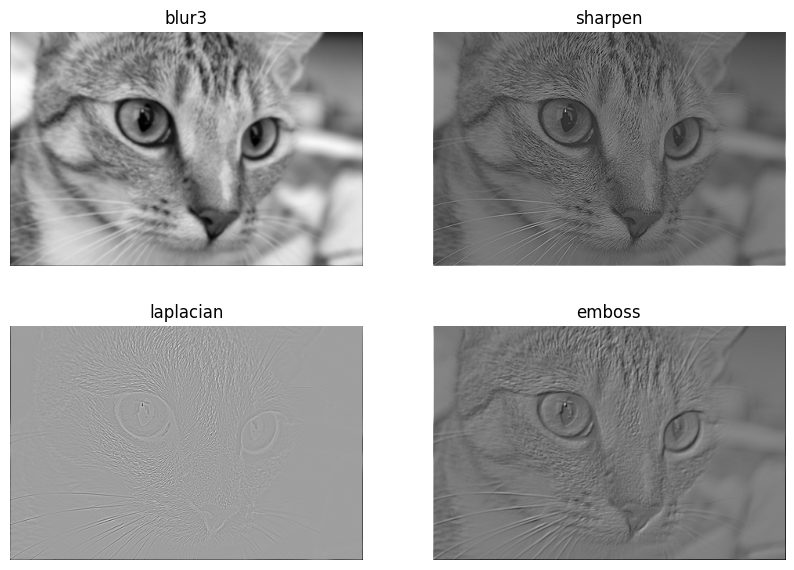

In [21]:
fig = plt.figure(figsize=(10, 7))
for i in range(len(kernels)):
    ax = plt.subplot(2, 2, i + 1)
    convolution = convolve(cat, kernels[i])
    plt.imshow(convolution, cmap=cm.gray)
    plt.title(kernel_labels[i])
    plt.axis('off')
plt.show()

## Automated classification of material microstructure : our First ConvNet

This model adopts a very classical architecture, so it is perfect to get started with CNN. It can be summarized as:

```INPUT => 3 x (CONV => RELU => POOLING) => FC(128) => FC(3)```

### As usual start by loading our data set

Here we will work with microstructure images with 3 classes: A, B and C.

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

with np.load('micrographs_64.npz') as data:
  X = data['X']
  y = data['y']
  labels = data['labels']

# observe that each image is 3D with one channel (gray level images)
print('data set contains %d images of size %d x %d x %d' % (X.shape[0], X.shape[1], X.shape[2], X.shape[3]))

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 32

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

data set contains 2880 images of size 64 x 64 x 1


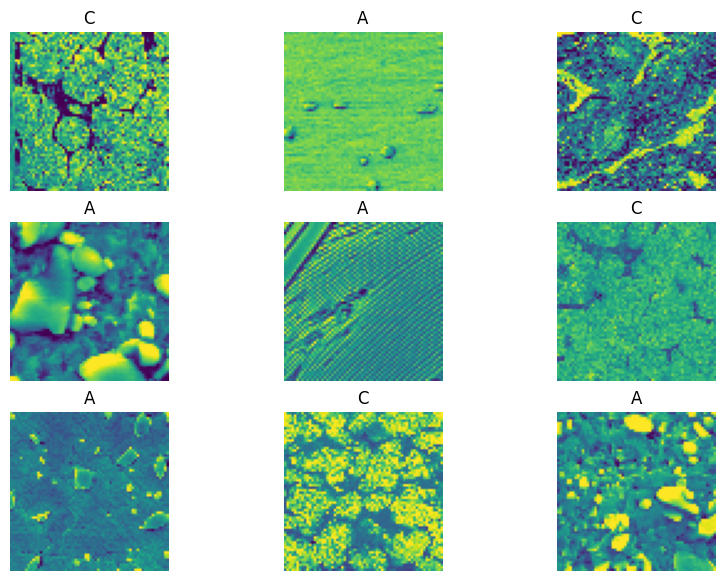

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
for images, image_labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(labels[image_labels[i]])
    plt.axis("off")

Partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing


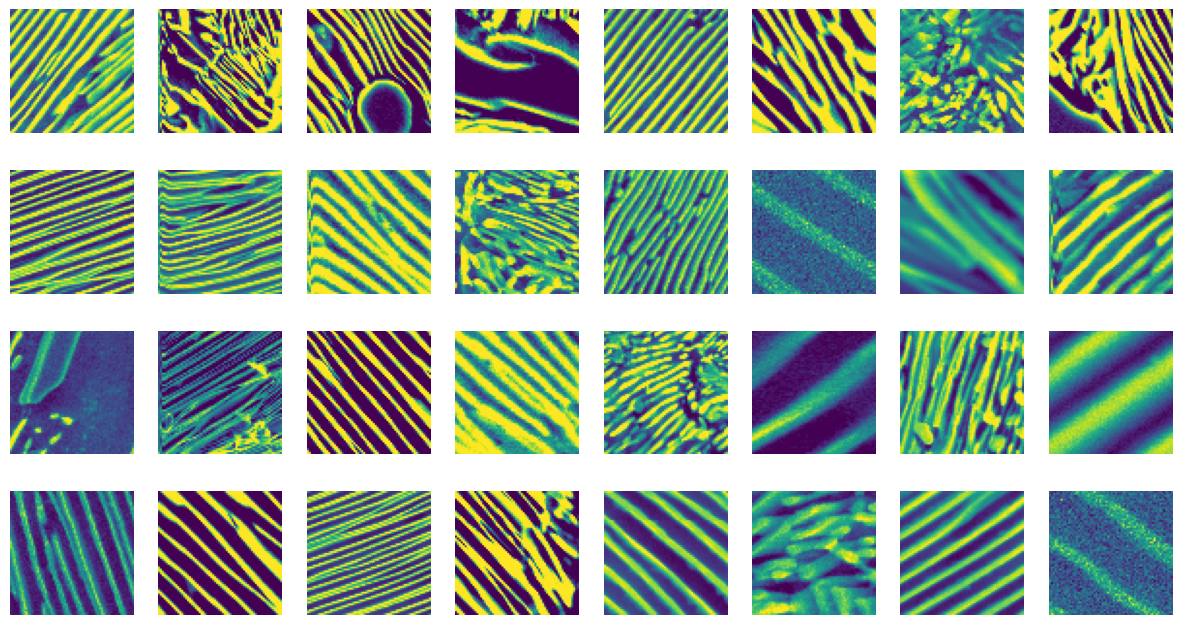

In [25]:
# display micrographs from a given class
class_A = X_train[np.where(y_train == 0)]
class_B = X_train[np.where(y_train == 1)]
class_C = X_train[np.where(y_train == 2)]
class_A.shape

N = 8
M = 4
indices = np.random.randint(0, class_B.shape[0], size=N*M)

plt.figure(figsize=(15, 8))
for i in range(N * M):
    ax = plt.subplot(M, N, i + 1)
    plt.imshow(class_B[indices[i]])
    plt.axis('off')
plt.show()

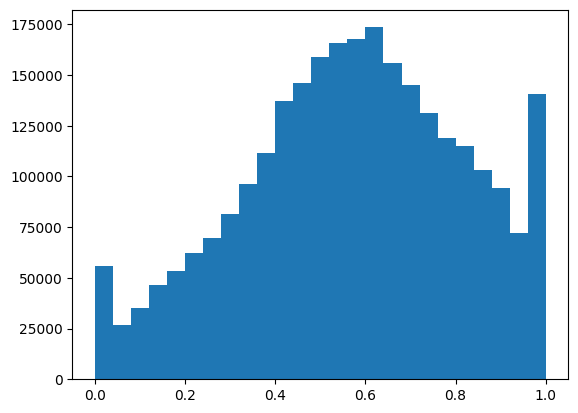

In [26]:
# check histograms
plt.hist(class_C.flatten(), bins=25)
plt.show()

### Build the model with Keras

start importing useful stuff from Keras

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = len(labels)

model = Sequential([
  layers.Conv2D(16, 3, padding='same', input_shape=(64, 64, 1), activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# train the model
epochs = 15
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4785 - loss: 1.0028 - val_accuracy: 0.6372 - val_loss: 0.7362
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6554 - loss: 0.7258 - val_accuracy: 0.7031 - val_loss: 0.6305
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7730 - loss: 0.5239 - val_accuracy: 0.7951 - val_loss: 0.5230
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8167 - loss: 0.4238 - val_accuracy: 0.8576 - val_loss: 0.4093
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8443 - loss: 0.3758 - val_accuracy: 0.8368 - val_loss: 0.4127
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8709 - loss: 0.3351 - val_accuracy: 0.8819 - val_loss: 0.3125
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9074 - loss: 0.2537 - val_accuracy: 0.9028 - val_loss: 0.3280
Epoch 8/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9079 - loss: 0.2377 - val_accuracy: 0.8993 - val_loss

In [ ]:
# train the model
epochs = 15
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
72/72 [==============================] - 10s 128ms/step - loss: 0.9795 - accuracy: 0.4701 - val_loss: 0.8272 - val_accuracy: 0.5590
Epoch 2/15
72/72 [==============================] - 10s 139ms/step - loss: 0.7575 - accuracy: 0.6406 - val_loss: 0.6229 - val_accuracy: 0.7135
Epoch 3/15
72/72 [==============================] - 12s 164ms/step - loss: 0.6449 - accuracy: 0.7118 - val_loss: 0.5599 - val_accuracy: 0.7118
Epoch 4/15
72/72 [==============================] - 16s 217ms/step - loss: 0.5062 - accuracy: 0.7904 - val_loss: 0.4645 - val_accuracy: 0.7865
Epoch 5/15
72/72 [==============================] - 9s 129ms/step - loss: 0.4169 - accuracy: 0.8368 - val_loss: 0.3881 - val_accuracy: 0.8507
Epoch 6/15
72/72 [==============================] - 10s 138ms/step - loss: 0.3276 - accuracy: 0.8702 - val_loss: 0.3209 - val_accuracy: 0.8785
Epoch 7/15
72/72 [==============================] - 10s 140ms/step - loss: 0.3010 - accuracy: 0.8841 - val_loss: 0.3264 - val_accuracy: 0.8802


Save our model to the disk (to reuse it later), this is called **serialization**. In Keras, the architecture of the model and the trained weights are save to a HDF5 file.

In [ ]:
model.save('microstructure_cnn.keras')

Now evaluate the network

In [29]:
predictions = model.predict(X_train, batch_size=32)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


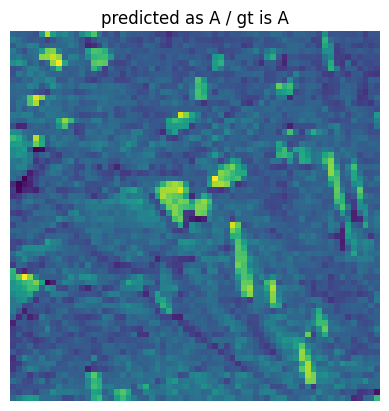

In [30]:
# on train data
index = 5
plt.imshow(X_train[index])
plt.title('predicted as %c / gt is %c' % (labels[predictions[index].argmax()], labels[y_train[index].argmax()]))
plt.axis('off')
plt.show()

In [31]:
predictions = model.predict(X_test, batch_size=32)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


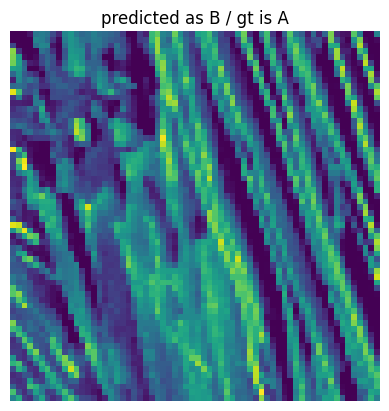

In [32]:
# on test data
index = 23
plt.imshow(X_test[index])
plt.title('predicted as %c / gt is %c' % (labels[predictions[index].argmax()], labels[y_test[index].argmax()]))
plt.axis('off')
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

           A       0.96      0.80      0.87       248
           B       0.86      0.91      0.88       154
           C       0.84      0.99      0.91       174

    accuracy                           0.89       576
   macro avg       0.89      0.90      0.89       576
weighted avg       0.90      0.89      0.89       576



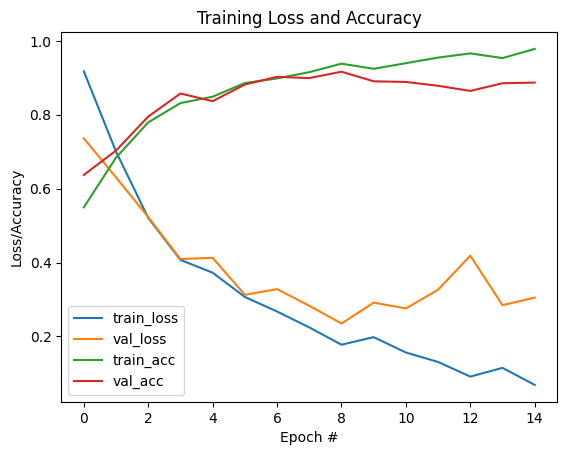

In [34]:
# plot the training loss and accuracy
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

## Using data augmentation and regularization

Finally for this tutorial we try this to use data augmentation since we may not have so many images and we start to see some overfitting in our learning phase.

Here we will use Keras tools to modify our traning images by flip/rotation/zoom to create new instances.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(64, 64, 1)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.2),
  ]
)

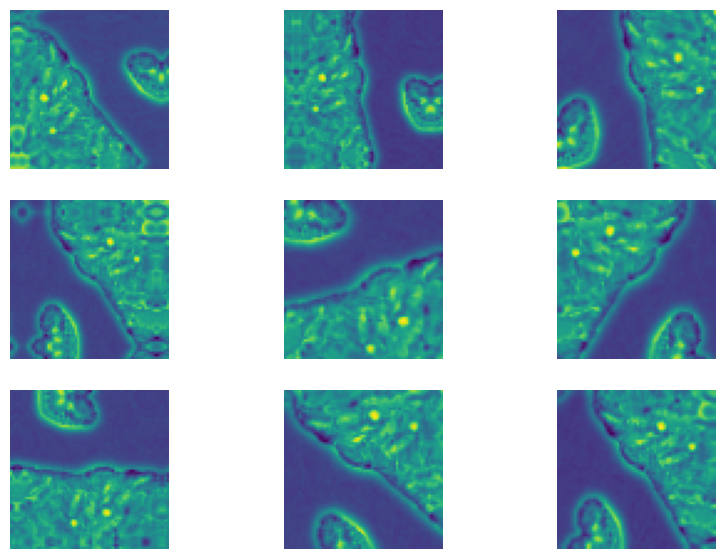

In [ ]:
plt.figure(figsize=(10, 7))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy())
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', input_shape=(64, 64, 1), activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

We can also try to compile our model with SGD + Momentum. use a learning rate of 0.01 and learning rate decay (15 epochs). Use the usual value for momentum and activate nesterov acceleration:

opt = SGD(learning_rate=0.01, decay=0.01 / 15, momentum=0.9, nesterov=True)


In [ ]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.01, weight_decay=0.01 / 15, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# train the model
epochs = 15
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
72/72 [==============================] - 13s 170ms/step - loss: 1.0600 - accuracy: 0.4861 - val_loss: 1.0382 - val_accuracy: 0.4653
Epoch 2/15
72/72 [==============================] - 10s 145ms/step - loss: 0.9306 - accuracy: 0.5616 - val_loss: 0.9309 - val_accuracy: 0.5503
Epoch 3/15
72/72 [==============================] - 11s 156ms/step - loss: 0.8628 - accuracy: 0.6107 - val_loss: 0.8629 - val_accuracy: 0.5833
Epoch 4/15
72/72 [==============================] - 12s 163ms/step - loss: 0.8105 - accuracy: 0.6306 - val_loss: 0.8175 - val_accuracy: 0.6198
Epoch 5/15
72/72 [==============================] - 12s 162ms/step - loss: 0.7639 - accuracy: 0.6536 - val_loss: 0.7719 - val_accuracy: 0.6476
Epoch 6/15
72/72 [==============================] - 11s 150ms/step - loss: 0.7318 - accuracy: 0.6771 - val_loss: 0.7577 - val_accuracy: 0.6597
Epoch 7/15
72/72 [==============================] - 11s 153ms/step - loss: 0.7190 - accuracy: 0.6884 - val_loss: 0.7698 - val_accuracy: 0.6580

Now evaluate the model.

In [ ]:
predictions = model.predict(X_test, batch_size=128)

5/5 [==============================] - 1s 118ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

           A       0.79      0.91      0.85       266
           B       0.82      0.66      0.73       155
           C       0.74      0.69      0.72       155

    accuracy                           0.78       576
   macro avg       0.78      0.75      0.76       576
weighted avg       0.79      0.78      0.78       576



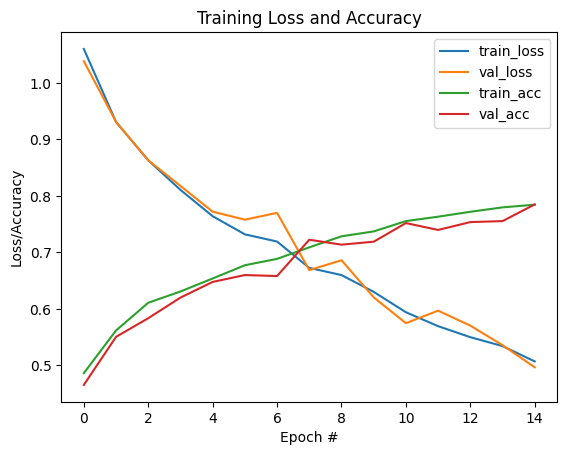

In [ ]:
# plot the training loss and accuracy
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

Finally label a few images with their prediction

In [ ]:
N = 8
M = 4
indices = np.random.randint(0, y_test.shape[0], size=N*M)

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(N * M):
    ax = plt.subplot(M, N, i + 1)
    plt.imshow(X_test[indices[i]])
    plt.axis('off')
    plt.title('%s' % labels[predictions[indices[i]].argmax()])
plt.show()